In [544]:
import re
import patsy
import pickle

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV

import warnings

In [521]:
def makeFormula(target, numeric=None, categoric=None, noInter = False, scale = False):
    formula = ""
    formula += target
    formula += "~"
    
    if(numeric != None):
        if scale == True:
            numeric = list(map(lambda c :  "scale(" + c + ")", numeric))
        formula_numeric = "+".join(numeric)
        formula += formula_numeric 
    
    if(numeric != None and categoric != None):
        formula += "+"
    
    if(categoric != None):
        categoric = list(map(lambda c :  "C(" + c + ")", categoric))
        formula_categoric = "+".join(categoric)
        formula += formula_categoric
    
    if(noInter == True):
        formula +="+0"
    
    return formula

# read file

In [522]:
df_train = pd.read_csv("../data/train_no_missing.csv")
df_test = pd.read_csv("../data/test_no_missing.csv")

nuTocaList = ["MSSubClass", "MoSold", "YrSold", "OverallQual", "OverallCond"]
df_train[nuTocaList] = df_train[nuTocaList].astype("str")
df_test[nuTocaList] = df_test[nuTocaList].astype("str")

df_all = pd.concat([df_train, df_test])
df_all.reset_index(drop = True, inplace = True)

df_all = pd.get_dummies(df_all)
df_train_dummy = df_all.iloc[:1460]
df_test_dummy = df_all.iloc[1460:]

df_train_dummy.reset_index(drop=True, inplace =True)
df_test_dummy.reset_index(drop=True, inplace =True)

df_test_dummy.drop("SalePriceLog", axis = 1, inplace = True)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [523]:
df_train.shape, df_test.shape, df_train_dummy.shape, df_test_dummy.shape

((1460, 81), (1459, 80), (1460, 351), (1459, 350))

# 0. Preprocessing

## 0-1. Treat missing value 

## 0-2. Feature Transform

### 0-2-1. Logarithm

### 0-2-2. Scaling

In [618]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_list = list(df_test.select_dtypes(include=numerics).columns)
print(len(numeric_list))

32


In [619]:
df_scale_numeric = pd.DataFrame()
# scale지정
for c in numeric_list:
    if c == "Id":
        continue
    df_scale_numeric[c+"Scale"] = scale(df_train[c])

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## 0-3. Delete Feature

In [620]:
df_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_scale_numeric.drop("GrLivAreaScale", axis = 1, inplace = True)

df_scale_numeric["SalePriceLog"] = df_train["SalePriceLog"]

### 0-3-1. VIF

In [621]:
df_X0 = df_scale_numeric.copy()
df_vif = pd.DataFrame()
df_vif["VIF Factor"] = [variance_inflation_factor(df_X0.values, i) for i in range(df_X0.shape[1])]
df_vif["features"] = df_X0.columns

df_vif.sort_values(by = "VIF Factor", ascending = False)
df_vif.reset_index(drop=True, inplace=True)
df_vif.head()

,VIF Factor,features
0,5.990182,FirstFlrSFScale
1,5.145018,SecondFlrSFScale
2,1.018991,ThreeSsnPorchScale
3,2.217294,BedroomAbvGrScale
4,5.348263,BsmtFinSF1Scale


# 1. Cleaning Numeric data

## 1-1. Cleaing the numueric data using t-test

In [529]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, None, False), df_scale_numeric)
result = model.fit()
ttest = result.pvalues
ttest.sort_values(ascending = False, inplace = True)
ttest_list = list(ttest.index)
ttest.head(10)

OpenPorchSFScale     0.764418
LotFrontageScale     0.659162
MiscValScale         0.558221
GarageYrBltScale     0.393172
BedroomAbvGrScale    0.288498
MasVnrAreaScale      0.281579
HalfBathScale        0.240719
LowQualFinSFScale    0.205184
BsmtHalfBathScale    0.183038
GarageAreaScale      0.167024
dtype: float64

In [530]:
# cross validation
df_y_test = df_scale_numeric["SalePriceLog"]
r2_test_list = []

for i in range(len(ttest_list)-1):
    df_X_test = df_scale_numeric[ttest_list[i:-1]]
    model = LinearRegression(fit_intercept = True)
    
    r2_sum = cross_val_score(model, df_X_test, df_y_test, scoring="r2", cv=5).sum()
    r2_test = r2_sum / 5
    r2_test_list.append(r2_test)

In [531]:
np.array(r2_test_list)

array([ 0.79256164,  0.79353501,  0.79769088,  0.79858009,  0.7987555 ,
        0.79915076,  0.79898416,  0.79880066,  0.79854201,  0.79900772,
        0.80138496,  0.80178653,  0.80091799,  0.80047649,  0.79935195,
        0.79852502,  0.79739664,  0.79729084,  0.79476245,  0.79204887,
        0.78937482,  0.79028481,  0.78906597,  0.76662707,  0.75331445,
        0.69848553,  0.38246973,  0.37572443,  0.3153367 ])

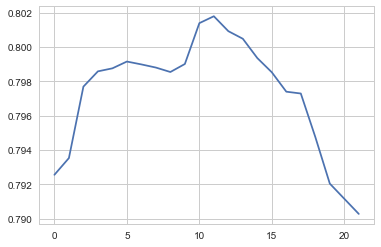

In [532]:
r2_test_list = np.array(r2_test_list)
r2_test_idx = np.where(r2_test_list > 0.79)
plt.plot(np.arange(len(ttest_list)-1)[r2_test_idx[0]], r2_test_list[r2_test_idx[0]])

In [533]:
#remove
numeric_list = ttest_list[8:-1]

## 1-2. Remove Outlier

In [556]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, None, False), df_scale_numeric)
result = model.fit()

predict = result.predict(df_scale_numeric).values
target = df_scale_numeric["SalePriceLog"].values

### 1-2-1. Patial plot

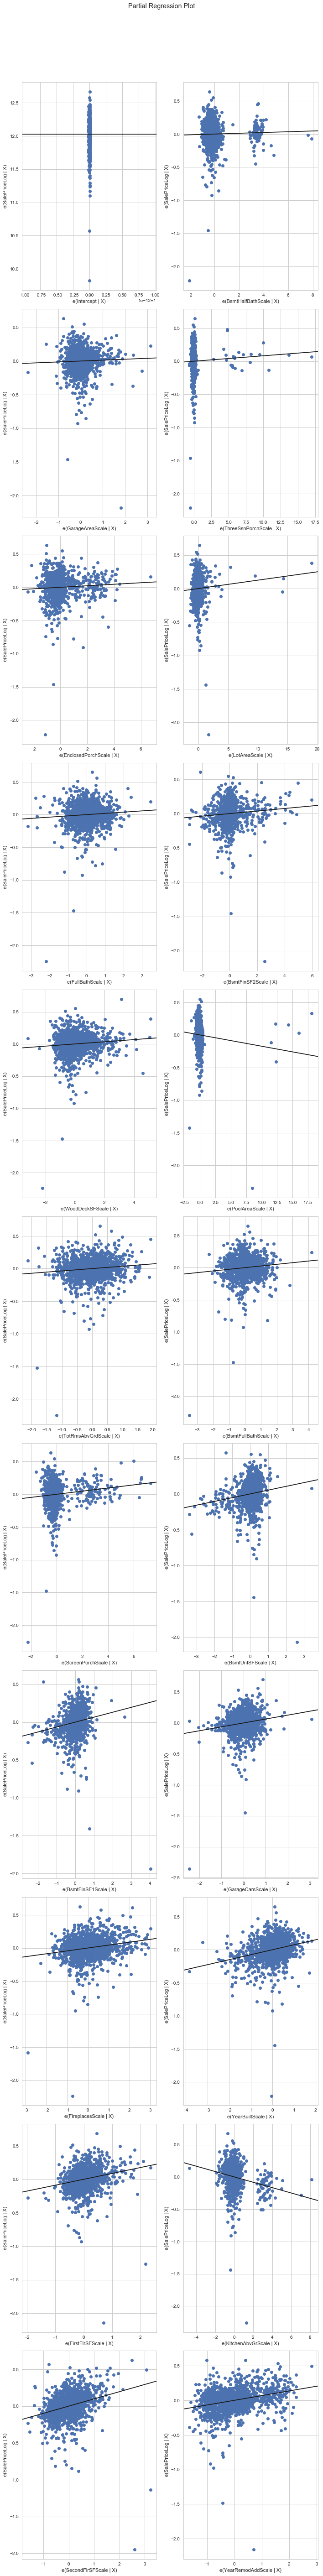

In [557]:
fig = plt.figure(figsize = (10, 80))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

### 1-2-2. Leverage - Standard residual

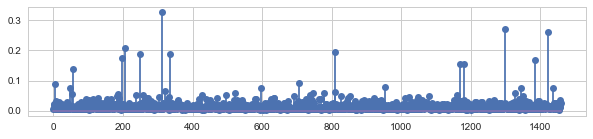

In [555]:
influence = result.get_influence()
hat = influence.hat_matrix_diag
plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

[   5   48   55  197  205  249  313  322  335  597  706  809  810  954 1170
 1182 1298 1346 1386 1423 1437]
21


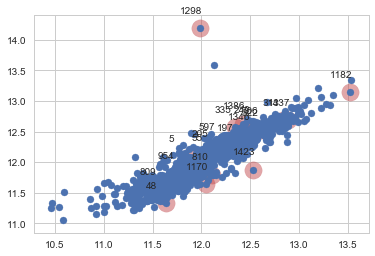

In [559]:
idx = np.where(hat > 4 * hat.mean())[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

print(idx)
print(len(idx))

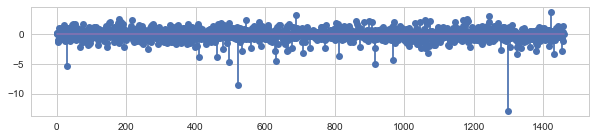

In [554]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.show()

[ 153  181  185  218  546  583  688  860  885  898  907  970 1046 1059 1075
 1147 1170 1181 1182 1243 1244 1423]
22


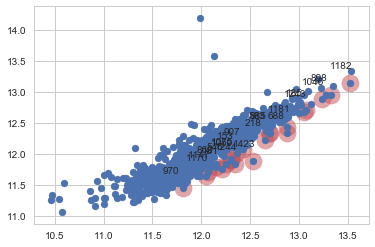

In [561]:
idx = np.where(result.resid_pearson > 2)[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

print(idx)
print(len(idx))

### 1-2-3. Qook's distance

[ 523  810 1170 1182 1298 1423]
6


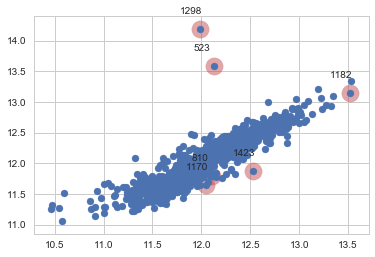

In [553]:
influence = result.get_influence()

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(target) -len(numeric_list) +1 - 1)
idx = np.where(cooks_d2 > 0.03)[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

print(idx)
print(len(idx))

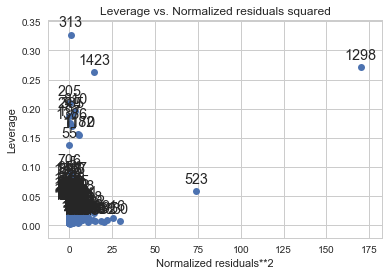

In [562]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

# 2. Cleaning the categorical data using one-way-table

## 2-1. Make dummy datas

In [563]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)
categoric_dummy_list = list(df_train_dummy.filter(regex = "_").columns)

df_scale_cate = pd.concat([df_scale_numeric, df_train[categoric_list]], axis = 1)
df_scale_cate_dummy = pd.concat([df_scale_numeric, df_train_dummy[categoric_dummy_list]], axis = 1)

len(categoric_list), len(categoric_dummy_list), df_scale_cate.shape, df_scale_cate_dummy.shape 

(48, 318, (1460, 78), (1460, 348))

## 2-2. One-way table

In [564]:
df_one_anova_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula("SalePriceLog ~ C({})".format(c), data=df_train)
    result = model.fit()
    df_tmp=sm.stats.anova_lm(result)
    df_one_anova_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}   

df_one_anova_Fvalue.sort_values(by=["Fvalue"], ascending=False, inplace=True)
df_one_anova_Fvalue.reset_index(drop=True, inplace=True)
df_one_anova_Fvalue.head(8)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,name,Fvalue
0,Utilities,0.629609
1,YrSold,0.565639
2,MoSold,0.449661
3,LandSlope,0.338834
4,Street,0.028380
5,Condition2,0.013820
6,PoolQC,0.007695
7,MiscFeature,0.006060


In [565]:
over_one_Fvalue_list = list(df_one_anova_Fvalue[:6]["name"])
# over_one_Fvalue_list

In [566]:
over_one_Fvalue_dummy_list=[]
for c in over_one_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_one_Fvalue_dummy_list.append(a)
        
# over_one_Fvalue_dummy_list

In [567]:
# 제거 high one-way Fvalue
for c in over_one_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_one_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)

In [568]:
len(categoric_list), len(over_one_Fvalue_list), len(categoric_dummy_list), len(over_one_Fvalue_dummy_list)

(42, 6, 286, 32)

## 2-3. Analysis categoric data using t-value

In [569]:
df_ttest_cate_dummy = pd.DataFrame(columns = ["Name", "t-value"])

for idx, c in enumerate(categoric_dummy_list):
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list + [c], None, False), df_scale_cate_dummy)
    result = model.fit()
    
    pvalues = result.pvalues
    
    df_ttest_cate_dummy.loc[idx] = {"Name" : c, "t-value": pvalues[c]}

df_ttest_cate_dummy.sort_values(by = ["t-value"], inplace = True)
df_ttest_cate_dummy.reset_index(drop=True, inplace=True)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [578]:
df_ttest_cate_dummy.head()

,Name,t-value
0,RoofMatl_ClyTile,2.508090e-56
1,PoolQC_None,1.321324e-22
2,MSZoning_all,4.561494e-17
3,OverallCond_3,4.726851e-17
4,Functional_Typ,2.215710e-15


In [579]:
(df_ttest_cate_dummy["t-value"] > 0.1).sum()

138

### Ridge CV

In [572]:
# cross validation
df_y_test = df_scale_numeric["SalePriceLog"]
ttest_cate_list = list(df_ttest_cate_dummy["Name"])
r2_test_list = []

for i in range(len(categoric_dummy_list)):
    r2_test = []
    for a in [0.1, 1, 10]:
        df_X_test = df_scale_cate_dummy[numeric_list + ttest_cate_list[:i+1]]
        model = Ridge(alpha = a, fit_intercept = True)
        r2_sum = cross_val_score(model, df_X_test, df_y_test, scoring="r2", cv=5).sum()
        
        r2_test.append(r2_sum / 5)

    r2_test_list.append(r2_test)

In [587]:
len(r2_test_idx), len(categoric_dummy_list)

(858, 131)

In [596]:
# r2_test_list = np.array(r2_test_list)
# r2_test_idx = np.where(r2_test_list > 0)
# plt.plot(np.arange(len(categoric_dummy_list))[r2_test_idx], r2_test_list[r2_test_idx])
# plt.legend([0.1, 1, 10])

IndexError: too many indices for array

In [600]:
r2_test_list[80:90]

array([[ 0.88156694,  0.88200642,  0.88007234],
       [ 0.88146182,  0.88191784,  0.88007177],
       [ 0.88261946,  0.883408  ,  0.88153729],
       [ 0.88395908,  0.88473111,  0.88266252],
       [ 0.88369322,  0.88468665,  0.88276588],
       [ 0.88329048,  0.88427734,  0.88235501],
       [ 0.88330596,  0.88429442,  0.88239357],
       [ 0.88340768,  0.88441416,  0.88258988],
       [ 0.88352151,  0.88452134,  0.88269375],
       [ 0.88231954,  0.88332856,  0.88197118]])

In [601]:
#remove categoric data
categoric_dummy_list = ttest_cate_list[:130+1]

## 2-4. Backward Elimination

In [602]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, categoric_dummy_list, False), df_scale_cate_dummy)
result = model.fit()

In [603]:
numeric_test_list = numeric_list.copy()
categoric_dummy_test_list = categoric_dummy_list.copy()

### 2-4-1.한번에 제거

In [604]:
# debug = False

# num_iter = 0
# isLoop = True

# while(isLoop):
#     num_iter += 1

#     model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_test_list, categoric_dummy_test_list, False), df_scale_cate_dummy)
#     result = model.fit()

#     pvalues = result.pvalues
#     pvalues.sort_values(ascending = False, inplace = True)
#     max_value = pvalues.values[0]
#     rm_index_list = list(pvalues[pvalues > 0.01].index)
#     rm_value_list = list(pvalues[pvalues > 0.01].values)
    
#     # C()제거
#     tmp_list = []
#     for idx in rm_index_list:
#         if re.match(r'C\((\w+)\)\S*', idx):
#             tmp_index = re.sub(r"C\((\w+)\)\S*", r"\g<1>", idx)
#             tmp_list.append(tmp_index)
#         else:
#             tmp_list.append(idx)
    
#     rm_index_list = tmp_list.copy()
    
#     if debug == True:
#         print("{} 단계 제거 목록: ".format(num_iter))
#         for i in range(len(rm_index_list)):
#             print("({}, {}) \n".format(rm_index_list[i], rm_value_list[i]), end=" ")
#         print()

#     if max_value > 0.01:
#         if numeric_test_list != None:
#             if max_index in numeric_test_list:
#                 numeric_test_list.remove(max_index)

#         if categoric_dummy_test_list != None:
#             if max_index in categoric_dummy_test_list:
#                 categoric_dummy_test_list.remove(max_index)
#         isLoop = True
#     else:
#         isLoop = False
    
#     isLoop = False

# print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
# print("numeric list : ", numeric_test_list)
# print("categoric list : ", categoric_dummy_test_list)
# print(len(numeric_test_list), len(categoric_dummy_test_list))

In [605]:
# numeric_list = numeric_test_list.copy()
# categoric_dummy_list = categoric_dummy_test_list.copy()

### 2-4-2. 하나씩 제거

In [606]:
debug = False

num_iter = 0
isLoop = True

while(isLoop):
    num_iter += 1

    model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_test_list, categoric_dummy_test_list, False), df_scale_cate_dummy)
    result = model.fit()

    pvalues = result.pvalues
    max_index = pvalues.sort_values(ascending = False).index[0]
    max_value = pvalues.sort_values(ascending = False).values[0]
    
    # C()제거
    if  re.match(r'C\((\w+)\)\S*', max_index):
        max_index = re.sub(r"C\((\w+)\)\S*", r"\g<1>", max_index)

    if debug == True:
        print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

    if max_value > 0.01:
        if numeric_test_list != None:
            if max_index in numeric_test_list:
                numeric_test_list.remove(max_index)

        if categoric_dummy_test_list != None:
            if max_index in categoric_dummy_test_list:
                categoric_dummy_test_list.remove(max_index)
        isLoop = True
    else:
        isLoop = False


print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
print("numeric list : ", numeric_test_list)
print("categoric list : ", categoric_dummy_test_list)
print(len(numeric_test_list), len(categoric_dummy_test_list))

84 시도만에 작업 끝!! : 정제된 목록 리스트 
numeric list :  ['GarageAreaScale', 'EnclosedPorchScale', 'LotAreaScale', 'FullBathScale', 'BsmtFinSF2Scale', 'WoodDeckSFScale', 'BsmtFullBathScale', 'ScreenPorchScale', 'BsmtUnfSFScale', 'BsmtFinSF1Scale', 'GarageCarsScale', 'FireplacesScale', 'YearBuiltScale', 'FirstFlrSFScale', 'KitchenAbvGrScale', 'SecondFlrSFScale', 'YearRemodAddScale']
categoric list :  ['RoofMatl_ClyTile', 'MSZoning_all', 'OverallCond_3', 'Functional_Typ', 'Neighborhood_Crawfor', 'OverallQual_9', 'KitchenQual_Ex', 'OverallQual_8', 'OverallCond_4', 'MSSubClass_160', 'CentralAir_N', 'CentralAir_Y', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Edwards', 'MSZoning_RM', 'OverallCond_7', 'SaleCondition_Abnorml', 'OverallQual_3', 'ExterQual_TA', 'Neighborhood_StoneBr', 'HeatingQC_Ex', 'Condition1_Norm', 'OverallQual_4', 'MSSubClass_30', 'Functional_Maj1', 'Functional_Maj2', 'Exterior1st_BrkFace', 'ExterQual_Gd', 'ExterQual_Fa', 'ExterQual_Ex', 'OverallCond_9', 'Foundation_P

In [608]:
numeric_list = numeric_test_list.copy()
categoric_dummy_list = categoric_dummy_test_list.copy()

In [609]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_test_list, categoric_dummy_test_list, False), df_scale_cate_dummy)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePriceLog   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     264.4
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        03:00:07   Log-Likelihood:                 1159.4
No. Observations:                1460   AIC:                            -2187.
Df Residuals:                    1394   BIC:                            -1838.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         5.9605      0.023    261.543      0.000       5.916       6.005
C(RoofMatl_ClyTile)[T.1]         -2.4262      0.131    -18.541      0.000      -2.683      -2.170
C(MSZoning_all)[T.1]             -0.4153      0.039    -10.595      0.000      -0.492      -0.338
C(OverallCond_3)[T.1]             0.3415      0.039      8.703      0.000       0.265       0.419
C(Functional_Typ)[T.1]            0.9892      0.019     51.556      0.000       0.952       1.027
C(Neighborhood_Crawfor)[T.1]      0.1312      0.018      7.457      0.000       0.097       0.166
C(OverallQual_9)[T.1]             0.1325      0.023      5.866      0.000       0.088       0.177
C(KitchenQual_Ex)[T.1]            0.0536      0.016      3.349      0.001       0.022       0.085
C(OverallQual_8)[T.1]             0.0616      0.012      5.341      0.000       0.039       0.084
C(OverallCond_4)[T.1]             0.4626      0.039     11.976      0.000       0.387       0.538
C(MSSubClass_160)[T.1]           -0.0946      0.017     -5.421      0.000      -0.129      -0.060
C(CentralAir_N)[T.1]              2.9595      0.014    206.245      0.000       2.931       2.988
C(CentralAir_Y)[T.1]              3.0010      0.013    232.492      0.000       2.976       3.026
C(Neighborhood_MeadowV)[T.1]     -0.1411      0.031     -4.591      0.000      -0.201      -0.081
C(Neighborhood_NridgHt)[T.1]      0.0792      0.017      4.725      0.000       0.046       0.112
C(Neighborhood_Edwards)[T.1]     -0.0542      0.013     -4.190      0.000      -0.080      -0.029
C(MSZoning_RM)[T.1]              -0.0627      0.011     -5.966      0.000      -0.083      -0.042
C(OverallCond_7)[T.1]             0.5798      0.037     15.501      0.000       0.506       0.653
C(SaleCondition_Abnorml)[T.1]    -0.0662      0.012     -5.450      0.000      -0.090      -0.042
C(OverallQual_3)[T.1]            -0.1115      0.028     -3.946      0.000      -0.167      -0.056
C(ExterQual_TA)[T.1]              1.4615      0.012    124.288      0.000       1.438       1.485
C(Neighborhood_StoneBr)[T.1]      0.1097      0.025      4.440      0.000       0.061       0.158
C(HeatingQC_Ex)[T.1]              0.0289      0.008      3.757      0.000       0.014       0.044
C(Condition1_Norm)[T.1]           0.0616      0.009      6.819      0.000       0.044       0.079
C(OverallQual_4)[T.1]            -0.0447      0.013     -3.572      0.000      -0.069      -0.020
C(MSSubClass_30)[T.1]            -0.0805      0.016     -4.972      0.000      -0.112      -0.049
C(Functional_Maj1)[T.1]           0.9061      0.033     27.287      0.000       0.841       0.971
C(Functional_Maj2)[T.1]           0.7719      0.053     14.536      0.000       0.668       0.876
C(Exterior1st_BrkFace)[T.1]       0.0744     

# 3. Multiponimal Regression + Lasso, Ridge, Elastic Net

## 3-1. Make square, squared by 3 data

In [390]:
#make square data
df_scale_pow2 = pd.DataFrame()

for c in numeric_list:
    if c == "SalePriceLog":
        continue
    
    df_scale_pow2[c+"pow2"] = df_scale_numeric[c].values ** 2
    
df_scale_pow2.shape

(1460, 29)

In [391]:
#make square data
df_scale_pow3 = pd.DataFrame()

for c in numeric_list:
    if c == "SalePriceLog":
        continue
        
    df_scale_pow3[c+"pow3"] = df_scale_numeric[c].values ** 3
    
df_scale_pow3.shape

(1460, 29)

In [393]:
df_all_feature = df_scale_numeric.copy()

# make all feature dataframe (scale + scale ** 2 + scale ** 3. categoric)
df_all_feature = pd.concat([df_scale_numeric, df_train_dummy[categoric_dummy_list]], axis = 1)
df_all_feature = pd.concat([df_all_feature, df_scale_pow2, df_scale_pow3], axis = 1)
df_all_feature.shape

(1460, 219)

In [394]:
all_feature_list = list(df_all_feature.columns)
all_feature_list.remove("SalePriceLog")

In [396]:
len(all_feature_list)

218

## 3-2. Lasso Regression

In [402]:
df_y_lasso = df_all_feature["SalePriceLog"]
df_X_lasso = df_all_feature[all_feature_list]

In [446]:
# setting lasso regression
alpha_lasso_list = np.logspace(-3, 0, 400)

In [474]:
# params_lasso_list = [] # lasso 확인 시 사용
# r2_lasso_list = []

# for idx, a in enumerate(alpha_lasso_list):
#     model = Lasso(alpha=a, fit_intercept = True).fit(df_X_lasso, df_y_lasso)
    
#     r2_sum = cross_val_score(model, df_X_lasso, df_y_lasso, scoring="r2", cv=5).sum()
#     r2_test = r2_sum / 5
            
#     r2_lasso_list.append(r2_test)
#     params_lasso_list.append(model.coef_)
    
#     print("{} 차 시도 !!".format(idx))
#     print("r2_lasso : {}".format(r2_test))
#     print()

In [451]:
# # 결과 pickle 저장
# pickle.dump(params_lasso_list, open("../data/lasso_params.p", "wb"))
# pickle.dump(r2_lasso_list, open("../data/lasso_r2.p", "wb"))
# pickle.dump(alpha_lasso_list, open("../data/lasso_alpha.p", "wb"))

# # 결과 pickle 불러오기
# params_lasso_list = pickle.load(open("../data/lasso_params.p", "rb"))
# r2_lasso_list = pickle.load(open("../data/lasso_r2.p", "rb"))
# alpha_lasso_list = pickle.load(open("../data/lasso_alpha.p", "rb"))

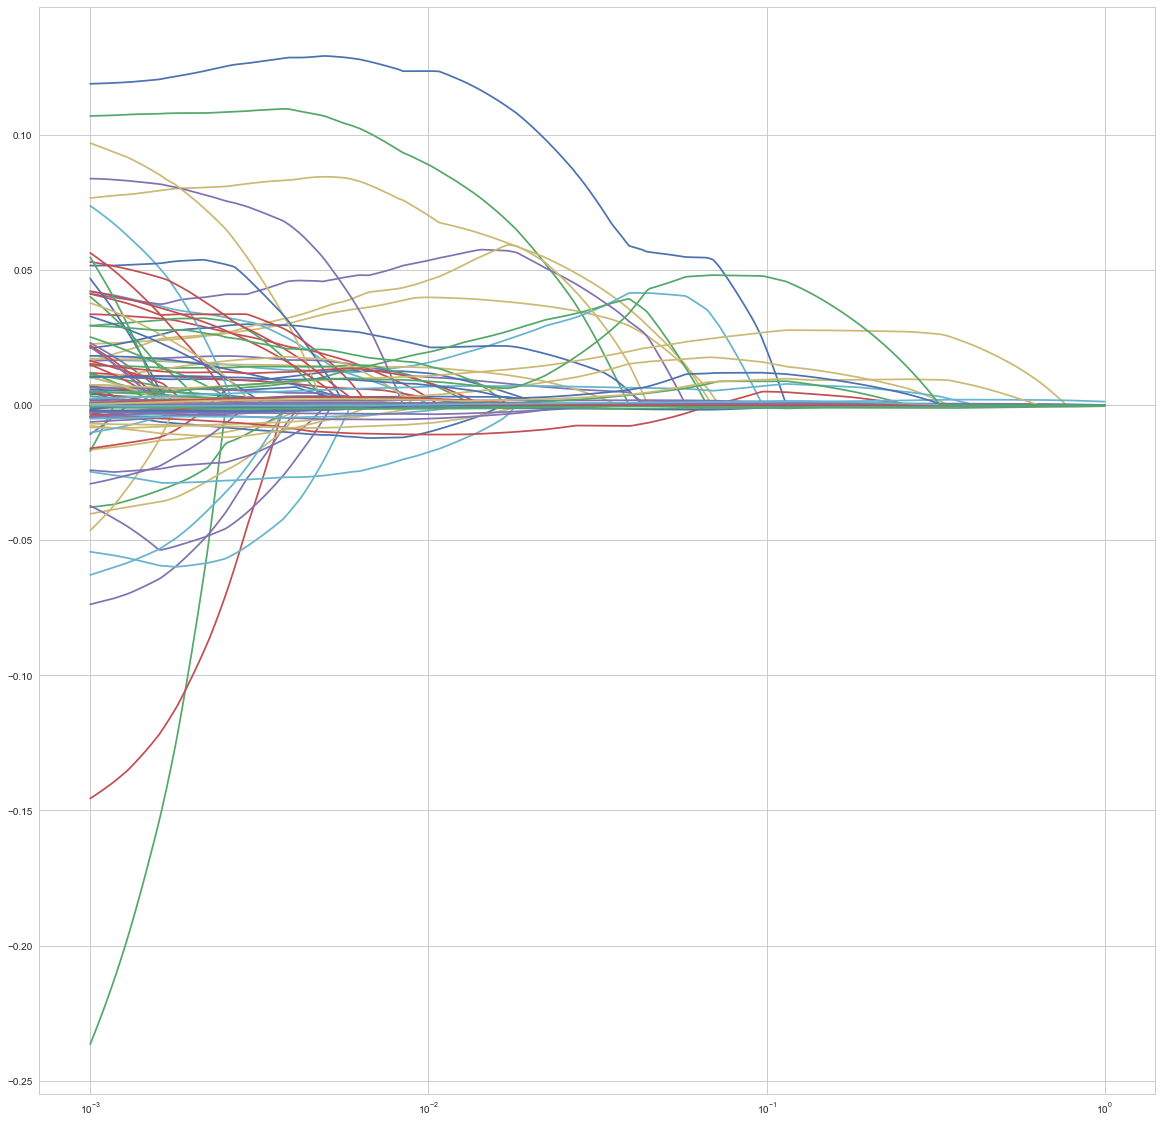

In [449]:
# plot about weight

df_lasso_params = pd.DataFrame(params_lasso_list, index = alpha_lasso_list)
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_lasso_params)

plt.show()

Text(0,0.5,'test_r2')

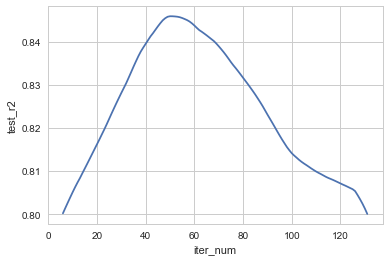

In [452]:
# plot r2 score
r2_lasso_list = np.array(r2_lasso_list)
r2_lasso_idx = np.where(r2_lasso_list > 0.8)
r2_lasso_idx[0]

plt.plot(r2_lasso_idx[0], r2_lasso_list[r2_lasso_idx])
plt.xlabel("iter_num")
plt.ylabel("test_r2")

In [453]:
r2_lasso_list[40:60]

array([ 0.83951693,  0.84038815,  0.84125024,  0.84197445,  0.84276522,
        0.84355124,  0.84428405,  0.84495359,  0.84543714,  0.84577954,
        0.845898  ,  0.84589084,  0.84585071,  0.84578973,  0.84567259,
        0.84548517,  0.84525049,  0.84500003,  0.84467233,  0.84424356])

In [454]:
alpha_lasso_list[11]

0.0012097810206889014

## 3-3. Ridge Regression

In [424]:
df_y_ridge = df_all_feature["SalePriceLog"]
df_X_ridge = df_all_feature[all_feature_list]

In [436]:
# setting Ridge regression
alpha_ridge_list = np.logspace(1, 3, 400)

In [448]:
# params_ridge_list = [] # lasso 확인 시 사용
# r2_ridge_list = []

# for idx, a in enumerate(alpha_ridge_list):
#     model = Ridge(alpha=a, fit_intercept = True).fit(df_X_ridge, df_y_ridge)
    
#     r2_sum = cross_val_score(model, df_X_ridge, df_y_ridge, scoring="r2", cv=5).sum()
#     r2_test = r2_sum / 5
            
#     r2_ridge_list.append(r2_test)
#     params_ridge_list.append(model.coef_)
    
#     print("{} 차 시도 !!".format(idx))
#     print("r2_ridge : {}".format(r2_test))
#     print()

In [438]:
# 결과 pickle 저장
pickle.dump(params_ridge_list, open("../data/ridge_params.p", "wb"))
pickle.dump(r2_ridge_list, open("../data/ridge_r2.p", "wb"))
pickle.dump(alpha_ridge_list, open("../data/ridge_alpha.p", "wb"))

# 결과 pickle 불러오기
params_ridge_list = pickle.load(open("../data/ridge_params.p", "rb"))
r2_ridge_list = pickle.load(open("../data/ridge_r2.p", "rb"))
alpha_ridge_list = pickle.load(open("../data/ridge_alpha.p", "rb"))

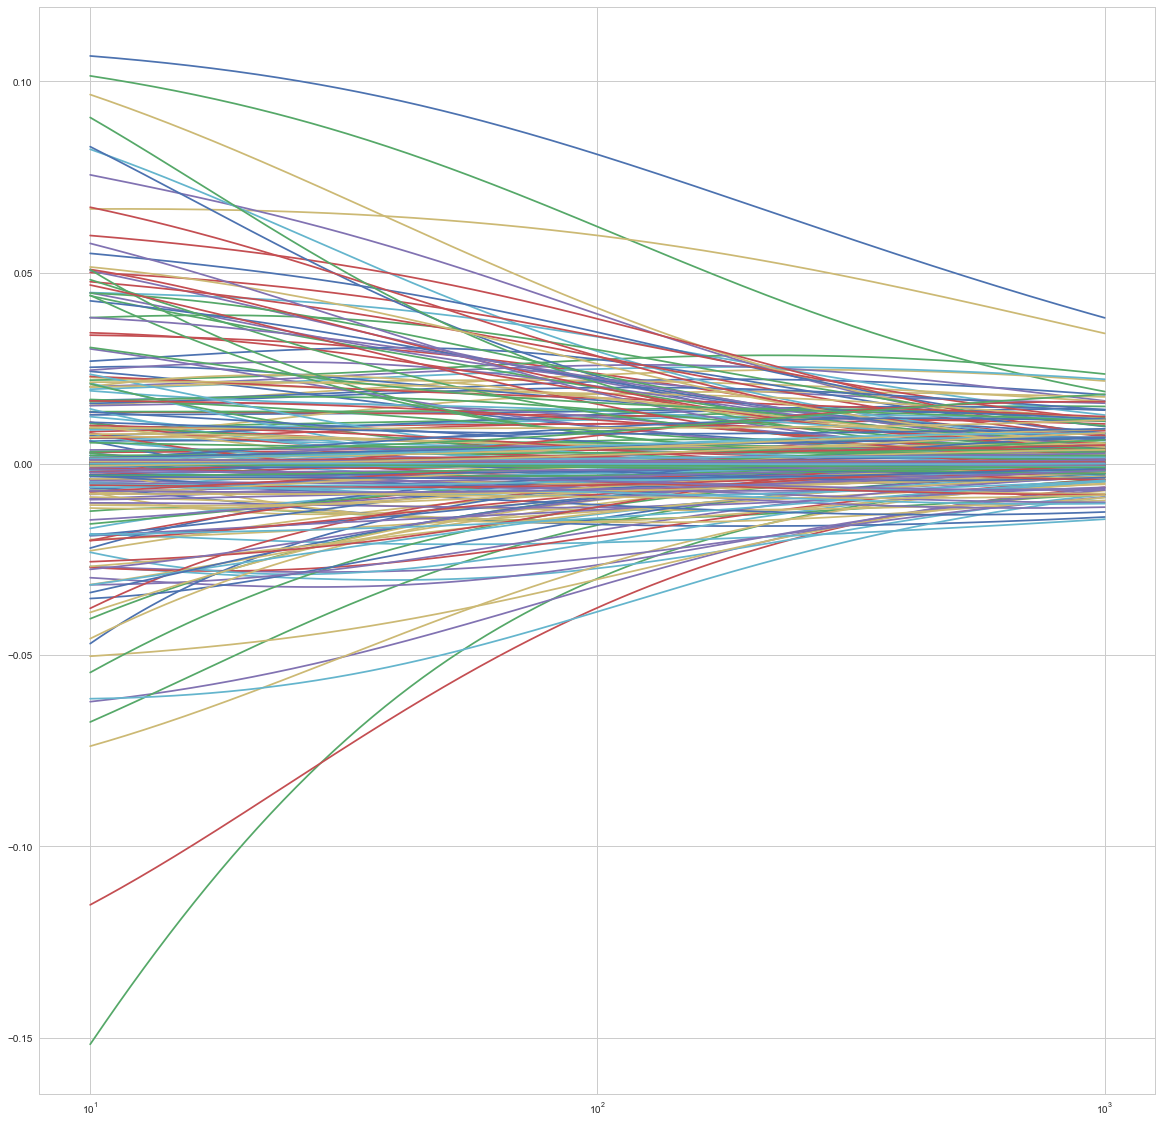

In [439]:
# plot about weight
df_ridge_params = pd.DataFrame(params_ridge_list, index = alpha_ridge_list)
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_ridge_params)

plt.show()

Text(0,0.5,'test_r2')

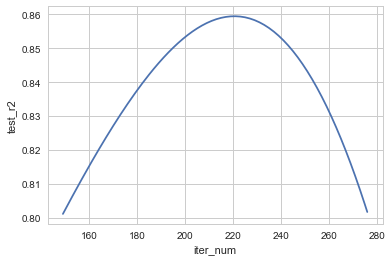

In [476]:
# plot r2 score
r2_ridge_list = np.array(r2_ridge_list)
r2_ridge_idx = np.where(r2_ridge_list > 0.8)
r2_ridge_idx[0]

plt.plot(r2_ridge_idx[0], r2_ridge_list[r2_ridge_idx])
plt.xlabel("iter_num")
plt.ylabel("test_r2")

In [475]:
r2_ridge_list[219:230]

array([ 0.85943643,  0.85946971,  0.85947155,  0.8594416 ,  0.85937948,
        0.85928483,  0.85915729,  0.8589965 ,  0.85880211,  0.85857376,
        0.85831111])

In [477]:
alpha_ridge_list[221]

128.16499459957583

## 3-4 Elastic net Regression

In [455]:
df_y_elastic = df_all_feature["SalePriceLog"]
df_X_elastic = df_all_feature[all_feature_list]

In [459]:
# setting ElasticNet regression
alpha_elastic_list = np.logspace(-3, 1, 400)

In [473]:
# params_elastic_list = [] # lasso 확인 시 사용
# r2_elastic_list = []

# for idx, a in enumerate(alpha_elastic_list):
#     model = ElasticNet(alpha=a, l1_ratio=0.5, fit_intercept = True).fit(df_X_elastic, df_y_elastic)
    
#     r2_sum = cross_val_score(model, df_X_elastic, df_y_elastic, scoring="r2", cv=5).sum()
#     r2_test = r2_sum / 5
            
#     r2_elastic_list.append(r2_test)
#     params_elastic_list.append(model.coef_)
    
#     print("{} 차 시도 !!".format(idx))
#     print("r2_elastic : {}".format(r2_test))
#     print()

In [461]:
# 결과 pickle 저장
pickle.dump(params_elastic_list, open("../data/elastic_params.p", "wb"))
pickle.dump(r2_elastic_list, open("../data/elastic_r2.p", "wb"))
pickle.dump(alpha_elastic_list, open("../data/elastic_alpha.p", "wb"))

# 결과 pickle 불러오기
params_elastic_list = pickle.load(open("../data/elastic_params.p", "rb"))
r2_elastic_list = pickle.load(open("../data/elastic_r2.p", "rb"))
alpha_elastic_list = pickle.load(open("../data/elastic_alpha.p", "rb"))

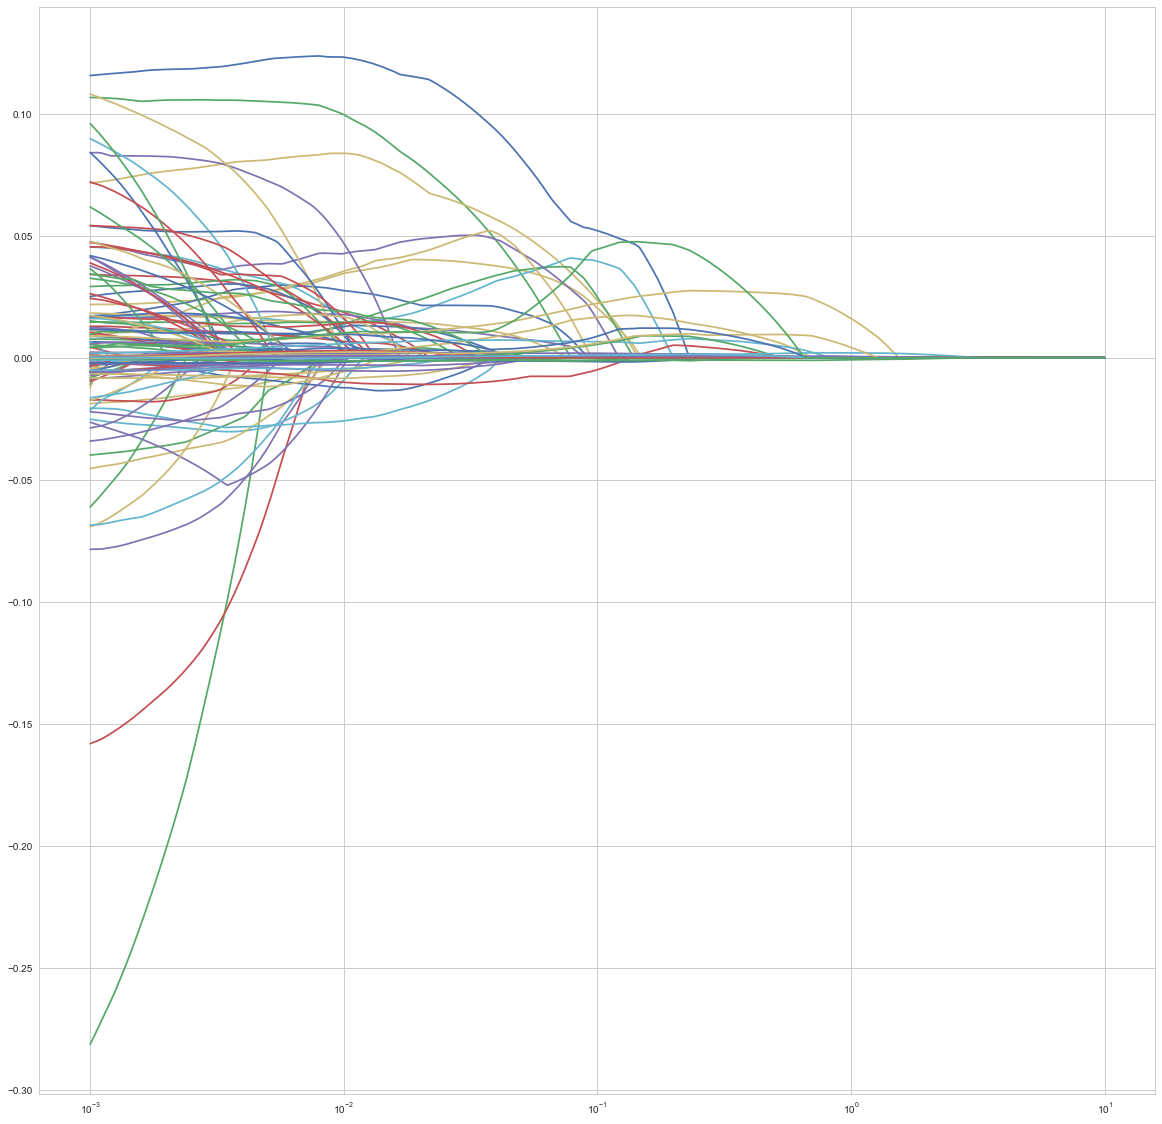

In [462]:
# plot about weight
df_elastic_params = pd.DataFrame(params_elastic_list, index = alpha_elastic_list)
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_elastic_params)

plt.show()

Text(0,0.5,'test_r2')

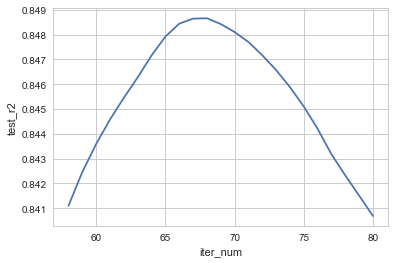

In [478]:
# plot r2 score
r2_elastic_list = np.array(r2_elastic_list)
r2_elastic_idx = np.where(r2_elastic_list > 0.84)
r2_elastic_idx[0]

plt.plot(r2_elastic_idx[0], r2_elastic_list[r2_elastic_idx])
plt.xlabel("iter_num")
plt.ylabel("test_r2")

In [465]:
r2_elastic_list[65:70]

array([ 0.84791728,  0.84843827,  0.84864267,  0.84865774,  0.84842358])

In [466]:
alpha_elastic_list[68]

0.0048051202513612421

# 4. Result

In [377]:
# model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list, None, True), df_scale_cate_dummy)
# result = model.fit()
# print(result.summary())

In [378]:
# plot_pre_tar(result, df_scale_cate_dummy, "SalePriceLog")

In [379]:
# # 잔차의 정규성 확인
# sp.stats.probplot(result.resid, plot =plt)

In [380]:
# crossValidation(df_train, makeFormula_scale("SalePriceLog", None, numeric_list+categoric_list, True), 10, 100)

# Special. Make submit test

In [468]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_list = list(df_test.select_dtypes(include=numerics).columns)

df_test_scale_numeric = pd.DataFrame()
# scale지정
for c in numeric_list:
    if c == "Id":
        continue
    df_test_scale_numeric[c+"Scale"] = scale(df_test[c])
    
df_test_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_test_scale_numeric.drop("GrLivAreaScale", axis = 1, inplace = True)

numeric_list = list(df_test_scale_numeric.columns)
# df_test_scale_numeric

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [469]:
#make square data
df_test_scale_pow2 = pd.DataFrame()

for c in numeric_list:
    df_test_scale_pow2[c+"pow2"] = df_test_scale_numeric[c].values ** 2
    
df_test_scale_pow2.shape

(1459, 29)

In [470]:
#make square data
df_test_scale_pow3 = pd.DataFrame()

for c in numeric_list:
    df_test_scale_pow3[c+"pow3"] = df_test_scale_numeric[c].values ** 3
    
df_test_scale_pow3.shape

(1459, 29)

In [471]:
# make all feature dataframe (scale + scale ** 2 + scale ** 3. categoric)
df_test_all_feature = pd.concat([df_test_scale_numeric, df_test_scale_pow2, df_test_scale_pow3, df_test_dummy[categoric_dummy_list]], axis = 1)
df_test_all_feature.shape

(1459, 218)

0.0012097810206889014 : lasso
128.16499459957583 : ridge
0.0048051202513612421 : elasticNet

In [517]:
# df_X_train = df_all_feature.filter(items = all_feature_list)
# df_y_train = df_all_feature["SalePriceLog"]
# df_X_test = df_test_all_feature.filter(items = all_feature_list)

df_X_train = df_all_feature.filter(items = numeric_test_list + categoric_dummy_test_list)
df_y_train = df_all_feature["SalePriceLog"]
df_X_test = df_test_all_feature.filter(items = numeric_test_list + categoric_dummy_test_list)

#모델 생성
# model = Lasso(alpha = 0.0012097810206889014, fit_intercept = True).fit(df_X_train, df_y_train)
# model = Ridge(alpha = 128.16499459957583 , fit_intercept = True).fit(df_X_train, df_y_train)
# model = ElasticNet(alpha = 0.0048051202513612421, l1_ratio=0.5, fit_intercept = True).fit(df_X_train, df_y_train)
model = LinearRegression(fit_intercept = False).fit(df_X_train, df_y_train)

# 계산
y = model.predict(df_X_test)
y = np.exp(y)
print(y)

# sumit 만들기
df_sumit = pd.DataFrame(columns = ["Id", "SalePrice"])
df_sumit["Id"] =df_test["Id"]
df_sumit["SalePrice"] = y

df_sumit.to_csv("../submit/submit.csv", index = False)

[ 127528.98315794  143658.93816088  187494.56921994 ...,  178961.52453867
  126709.08237693  238976.93752328]


C:\Users\magenta_jy\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
